In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split,KFold,cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance, plot_partial_dependence, partial_dependence
import xgboost as xgb

In [2]:
pd.options.display.max_columns = None

In [93]:
def model_checking(ax,model,X,Y):
    y_max = np.max(Y)
    ax.set_xlim([0,y_max])
    ax.set_ylim([0,y_max])
    ax.scatter(model.predict(X),Y,c='k',alpha=0.4,s=X.number_of_reviews)
    ax.plot([0,y_max],[0,y_max],c='r',ls='--')
    ax.set_xlabel('Predicted Price')
    ax.set_ylabel('Listing Price')
    
def model_checking_residual(ax,model,X,Y):
    new_Y = Y - model.predict(X)
    y_max = np.max(new_Y)
    ax.set_ylim([-y_max,y_max])
    ax.scatter(X,new_Y,c='k',alpha=0.4,s=X.number_of_reviews)
    #ax.plot([0,0],[0,0],c='r',ls='--')
    ax.set_xlabel('Listed Price')
    ax.set_ylabel('Residuals')
    
    

In [4]:
df_listing = pd.read_csv('Data/listings_details.csv')
df_reviews = pd.read_csv('Data/reviews_Details.csv')
df_scrape = pd.read_csv('Data/Airbnb_Description.csv')
df_listing.head(5)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2265,https://www.airbnb.com/rooms/2265,20210210181232,2021-02-12,Zen-East in the Heart of Austin (monthly rental),Zen East is situated in a vibrant & diverse mu...,NaN,https://a0.muscache.com/pictures/4740524/63f82...,2466,https://www.airbnb.com/users/show/2466,Paddy,2008-08-23,"Austin, Texas, United States",I am a long time resident of Austin. I earned ...,within a few hours,100%,90%,f,https://a0.muscache.com/im/users/2466/profile_...,https://a0.muscache.com/im/users/2466/profile_...,East Downtown,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,NaN,78702,NaN,30.27750,-97.71398,Entire house,Entire home/apt,4,NaN,2 baths,2.0,2.0,"[""Free parking on premises"", ""Hair dryer"", ""Pa...",$200.00,7,180,7.0,7.0,180.0,180.0,7.0,180.0,NaN,t,13,13,42,131,2021-02-12,24,0,0,2009-03-17,2019-03-16,93.0,9.0,10.0,10.0,10.0,8.0,9.0,NaN,f,3,2,1,0,0.17
1,5245,https://www.airbnb.com/rooms/5245,20210210181232,2021-02-12,"Eco friendly, Colorful, Clean, Cozy monthly share",Situated in a vibrant & diverse multicultural ...,NaN,https://a0.muscache.com/pictures/5167505/b33b5...,2466,https://www.airbnb.com/users/show/2466,Paddy,2008-08-23,"Austin, Texas, United States",I am a long time resident of Austin. I earned ...,within a few hours,100%,90%,f,https://a0.muscache.com/im/users/2466/profile_...,https://a0.muscache.com/im/users/2466/profile_...,East Downtown,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,NaN,78702,NaN,30.27577,-97.71379,Private room in house,Private room,2,NaN,1 private bath,1.0,2.0,"[""Free parking on premises"", ""Hair dryer"", ""Br...",$114.00,30,60,30.0,30.0,60.0,60.0,30.0,60.0,NaN,t,0,0,0,0,2021-02-12,9,0,0,2009-03-19,2018-03-14,91.0,10.0,8.0,10.0,9.0,10.0,9.0,NaN,f,3,2,1,0,0.06
2,5456,https://www.airbnb.com/rooms/5456,20210210181232,2021-02-12,"Walk to 6th, Rainey St and Convention Ctr",Great central location for walking to Convent...,My neighborhood is ideally located if you want...,https://a0.muscache.com/pictures/14084884/b5a3...,8028,https://www.airbnb.com/users/show/8028,Sylvia,2009-02-16,"Austin, Texas, United States",I am a licensed Real Estate Broker and owner o...,within a few hours,100%,91%,t,https://a0.muscache.com/im/users/8028/profile_...,https://a0.muscache.com/im/users/8028/profile_...,East Downtown,1.0,1.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Austin, Texas, United States",78702,NaN,30.26112,-97.73448,Entire guesthouse,Entire home/apt,3,NaN,1 bath,1.0,2.0,"[""Hair dryer"", ""Dishes and silverware"", ""Air c...",$104.00,2,90,2.0,2.0,90.0,90.0,2.0,90.0,NaN,t,24,54,84,354,2021-02-12,543,20,3,2009-03-08,2021-02-01,97.0,10.0,10.0,10.0,10.0,10.0,9.0,NaN,f,1,1,0,0,3.74
3,5636,https://www.a

In [5]:
df_listing.shape

(10272, 74)

## Performing EDA Analysis

In [6]:
# Removing unnecessary columns
columns_to_remove = ['scrape_id','last_scraped','neighbourhood_group_cleansed','calendar_updated','license','bathrooms',
                     'picture_url','host_has_profile_pic','host_name','host_url','host_thumbnail_url','name',
                     'minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights',
                     'minimum_nights_avg_ntm','maximum_nights_avg_ntm','has_availability','host_picture_url',
                     'number_of_reviews_l30d','number_of_reviews_ltm','calendar_last_scraped',
                     'calculated_host_listings_count','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms',
                     'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms','reviews_per_month',
                     'neighbourhood','host_about',
                     'latitude','longitude'] 
df_listing.drop(columns_to_remove,axis=1,inplace=True)

In [7]:
df_listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10272 entries, 0 to 10271
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           10272 non-null  int64  
 1   listing_url                  10272 non-null  object 
 2   description                  10064 non-null  object 
 3   neighborhood_overview        6545 non-null   object 
 4   host_id                      10272 non-null  int64  
 5   host_since                   10267 non-null  object 
 6   host_location                10247 non-null  object 
 7   host_response_time           6073 non-null   object 
 8   host_response_rate           6073 non-null   object 
 9   host_acceptance_rate         6850 non-null   object 
 10  host_is_superhost            10267 non-null  object 
 11  host_neighbourhood           8363 non-null   object 
 12  host_listings_count          10267 non-null  float64
 13  host_total_listi

### Renaming Columns

In [8]:
df_listing = df_listing.rename(columns={'neighbourhood_cleansed': 'zip_code'})

### Converting the columns data format

In [9]:
df_listing.first_review = pd.to_datetime(df_listing.first_review)
df_listing.last_review = pd.to_datetime(df_listing.last_review)
df_listing.host_since = pd.to_datetime(df_listing.host_since)

df_listing["Timeframe"] = (df_listing.last_review - df_listing.first_review).dt.days
df_listing.drop(['first_review','last_review'],axis=1,inplace=True)

In [10]:
# Filtering the prices and remove the highest ones due to SXSW festival
df_listing.price = df_listing.price.replace('[\$,]','',regex=True).astype(float)
df_listing = df_listing[df_listing.price<5200]

In [11]:
# Converting categories to numbers
df_listing.loc[:,'host_is_superhost'] = df_listing.host_is_superhost.map({'t':1,'f':0})
df_listing.loc[:,'instant_bookable'] = df_listing.instant_bookable.map({'t':1,'f':0})



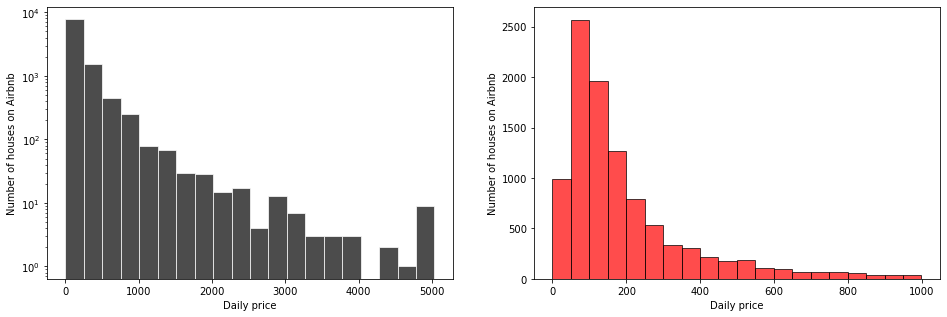

In [12]:
fig,axs = plt.subplots(1,2,figsize=(16,5))
axs[0].hist(df_listing.price,bins=20,color='k',alpha=0.7,edgecolor='w')
axs[0].set_yscale('log');
axs[0].set_xlabel('Daily price');
axs[0].set_ylabel('Number of houses on Airbnb');
axs[0].grid(b='None');
axs[0].grid(None);
axs[1].hist(df_listing.price[df_listing.price<1000],bins=20,color='r',alpha=0.7,edgecolor='k');
axs[1].set_xlabel('Daily price');
axs[1].set_ylabel('Number of houses on Airbnb');
df_listing = df_listing[df_listing.price<800]

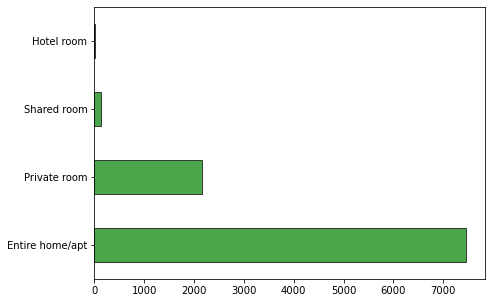

In [13]:
fig,axs = plt.subplots(figsize=(7,5))
df_listing.room_type.value_counts().plot(kind='barh',color='g',alpha=0.7,edgecolor='k');

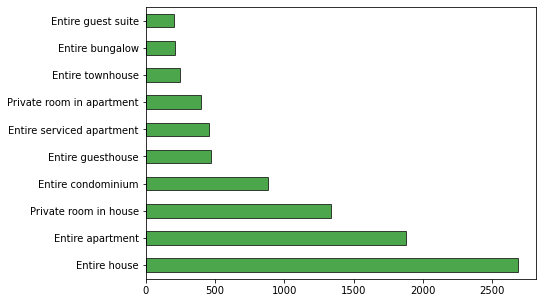

In [14]:
fig,ax = plt.subplots(figsize=(7,5))
df_listing.property_type.value_counts()[:10].plot(kind='barh',color='g',alpha=0.7,edgecolor='k');

In [15]:
#df_listing.info()

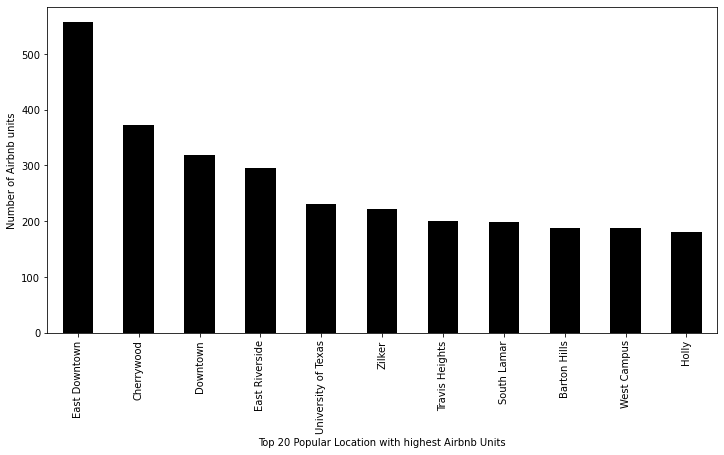

In [16]:
fig,ax = plt.subplots(figsize=(12,6));
ax = df_listing.host_neighbourhood.value_counts()[:11].plot.bar(color='k');
ax.set_ylabel('Number of Airbnb units');
ax.set_xlabel('Top 20 Popular Location with highest Airbnb Units');

In [17]:
dict_amenities = dict()
for lst in df_listing.amenities:
    for word in lst.replace('[','').replace('"','').replace(']','').replace(' ','').split(','):
        if word not in dict_amenities:
            dict_amenities[word] = 1
        else:
            dict_amenities[word] += 1

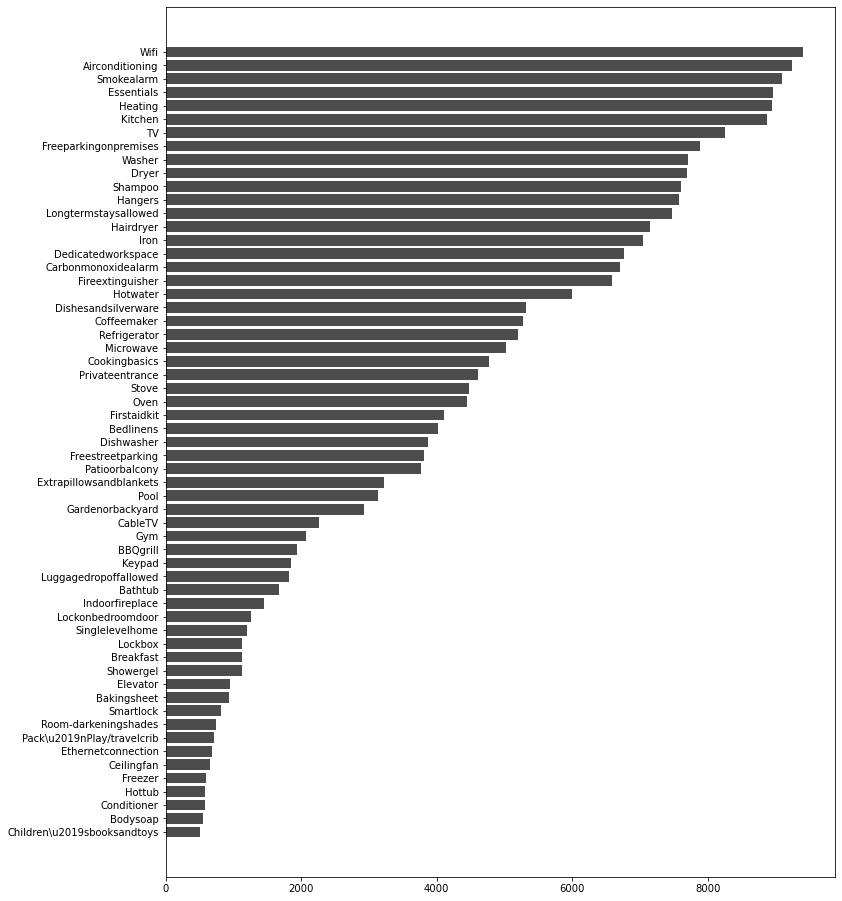

In [18]:
filtered_dict = {k:v for k,v in dict_amenities.items() if v>500}
filtered_dict = {k:v for k,v in sorted(filtered_dict.items(),key=lambda item:item[1])}

fig,ax = plt.subplots(figsize=(12,16))
a= list(filtered_dict.keys())
b= filtered_dict.values()
# ax.bar(a,b)
plt.barh(a,b,color='k',alpha=0.7);

In [19]:
## Features to keep
# bbqgrill, gym, pool,private_entrance

# Most expensive house
# https://www.airbnb.com/rooms/46081394/photos?guests=1&adults=1
# https://www.airbnb.com/luxury/listing/36868497?source_impression_id=p3_1616965432_%2BtiLPpKVsNjbcXS8&guests=1&adults=1&check_in=2021-04-07&check_out=2021-04-10
#https://www.airbnb.com/rooms/46081476/photos?source_impression_id=p3_1616965591_2THtdQLDDHYaRava

Text(0.5, 0, 'Host Locations')

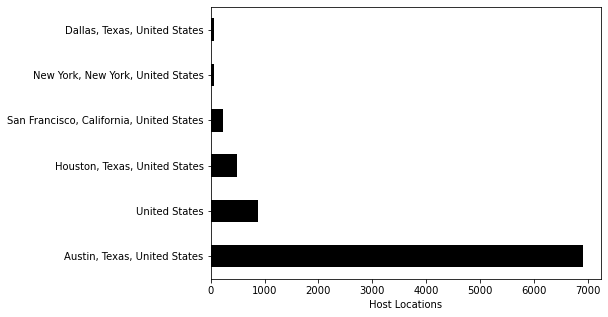

In [20]:
df_listing.host_location = df_listing.host_location.str.replace('US','United States')
fig,ax = plt.subplots(figsize=(7,5))
ax = df_listing.host_location.value_counts().head(6).plot(kind='barh',color='k')
ax.set_xlabel('Host Locations')

Text(0, 0.5, 'Median Price per Night')

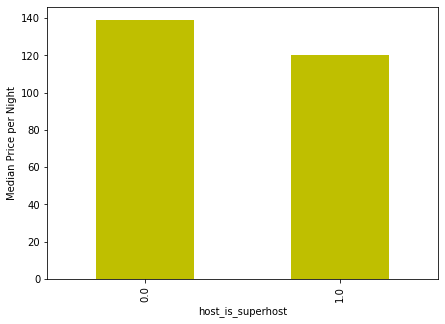

In [21]:
fig,ax = plt.subplots(figsize=(7,5));
df_listing.groupby('host_is_superhost').price.median().plot(kind='bar',color='y');
ax.set_ylabel('Median Price per Night')

In [22]:
df_listing.bedrooms = df_listing.bedrooms.fillna(0)

In [23]:
df_listing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9756 entries, 0 to 10271
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id                           9756 non-null   int64         
 1   listing_url                  9756 non-null   object        
 2   description                  9577 non-null   object        
 3   neighborhood_overview        6263 non-null   object        
 4   host_id                      9756 non-null   int64         
 5   host_since                   9751 non-null   datetime64[ns]
 6   host_location                9732 non-null   object        
 7   host_response_time           5783 non-null   object        
 8   host_response_rate           5783 non-null   object        
 9   host_acceptance_rate         6544 non-null   object        
 10  host_is_superhost            9751 non-null   float64       
 11  host_neighbourhood           7919 non-null

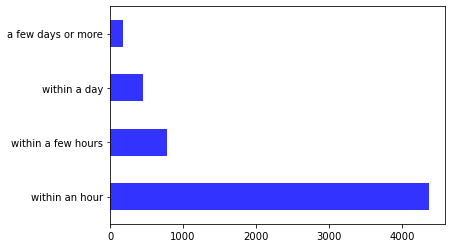

In [24]:
df_listing.host_response_time.value_counts().plot(kind='barh',color='b',alpha=0.8);

In [25]:
columns_to_remove2 = ['host_response_time','host_response_rate','host_neighbourhood'] 
df_listing.drop(columns_to_remove2,axis=1,inplace=True)

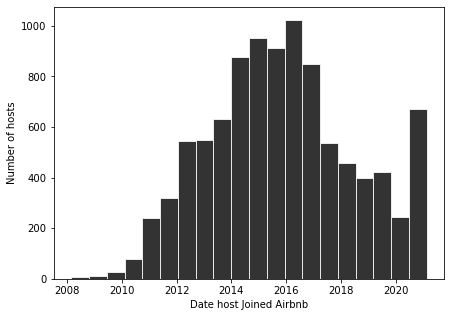

In [26]:
fig,ax = plt.subplots(figsize=(7,5))
df_listing.host_since.hist(bins=20,color='k',alpha=0.8,edgecolor='w')
ax.grid(None);
ax.set_xlabel('Date host Joined Airbnb');
ax.set_ylabel('Number of hosts');

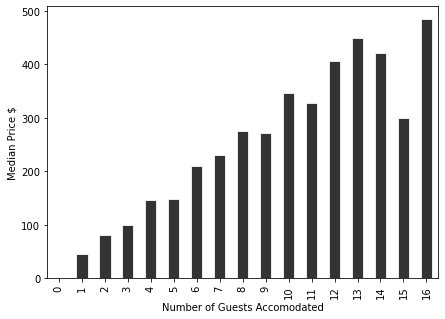

In [27]:
fig,ax = plt.subplots(figsize=(7,5))
ax = df_listing.groupby('accommodates').price.median().plot(kind='bar',color='k',alpha=0.8,edgecolor='w');
ax.set_xlabel('Number of Guests Accomodated');
ax.set_ylabel('Median Price $');

In [28]:
df_listing.room_type = df_listing.room_type.str.replace('Hotel room','Hotel_room')
df_listing.room_type = df_listing.room_type.str.replace('Private room','Private_room')
df_listing.room_type = df_listing.room_type.str.replace('Shared room','Shared_room')

dummies_room_type = pd.get_dummies(df_listing.room_type,prefix='room_type_',drop_first=True)

In [29]:
df_listing = pd.concat([df_listing,dummies_room_type],axis=1)
df_listing.drop('room_type',axis=1,inplace=True)

In [30]:
df_listing.bathrooms_text = df_listing.bathrooms_text.str.replace('1 private bath','1 bath')
df_listing.bathrooms_text = df_listing.bathrooms_text.str.replace('1 shared bath','0.5 bath')
df_listing.bathrooms_text = df_listing.bathrooms_text.str.replace('1.5 shared baths','0.75 bath')
df_listing.bathrooms_text = df_listing.bathrooms_text.str.replace('2 shared baths','1 bath')
df_listing.bathrooms_text = df_listing.bathrooms_text.str.replace('Half-bath','0.5 bath')
df_listing.bathrooms_text = df_listing.bathrooms_text.str.replace('4 shared baths','2 baths')
df_listing.bathrooms_text = df_listing.bathrooms_text.str.replace('2.5 shared baths','1.25 baths')
df_listing.bathrooms_text = df_listing.bathrooms_text.str.replace('3 shared baths','1.5 baths')
df_listing.bathrooms_text = df_listing.bathrooms_text.str.replace('Private half-bath','0.5 bath')
df_listing.bathrooms_text = df_listing.bathrooms_text.str.replace('0 shared baths','0 bath')
df_listing.bathrooms_text = df_listing.bathrooms_text.str.replace('2 bath','2 baths')
df_listing.bathrooms_text = df_listing.bathrooms_text.str.replace('0 baths','0 bath')
df_listing = df_listing[df_listing.bathrooms_text.notnull()]
df_listing['bathrooms'] = df_listing.bathrooms_text.apply(lambda x:float(x.split(' ')[0]))
df_listing.drop('bathrooms_text',axis=1,inplace=True)

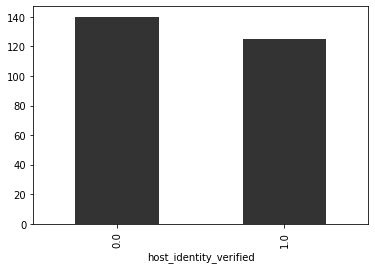

In [31]:
df_listing.loc[:,'host_identity_verified'] = df_listing.host_identity_verified.map({'t':1,'f':0});
df_listing.groupby('host_identity_verified').price.median().plot(kind='bar',color='k',alpha=0.8);

In [32]:
df_listing.drop('host_identity_verified',axis=1,inplace=True)
df_listing.drop('description',axis=1,inplace=True)
df_listing.drop('neighborhood_overview',axis=1,inplace=True)

In [33]:
property_type = ['Entire house','Entire apartment','Private room in house','Entire condominium','Entire guesthouse',             
'Entire serviced apartment','Private room in apartment','Entire townhouse','Entire bungalow','Entire guest suite']
df_listing.property_type = df_listing.property_type.apply(lambda x: 'other' if x not in property_type else x)
dummies_property_type = pd.get_dummies(df_listing.property_type,prefix='property_type',drop_first=True)
df_listing = pd.concat([df_listing,dummies_property_type],axis=1)
df_listing.drop('property_type',axis=1,inplace=True)

df_listing = df_listing.rename(columns={'neighbourhood_cleansed': 'zip_code',
                                        'property_type_Entire bungalow':'property_type_Entire_bungalow',                    
                                        'property_type_Entire condominium':'property_type_Entire_condominium',                
                                        'property_type_Entire guest suite':'property_type_Entire_guest_suite',             
                                        'property_type_Entire guesthouse': 'property_type_Entire_guesthouse',            
                                        'property_type_Entire house':'property_type_Entire_house',                      
                                        'property_type_Entire serviced apartment':'property_type_Entire_serviced_apartment',       
                                        'property_type_Entire townhouse':'property_type_Entire_townhouse',                  
                                        'property_type_Private room in apartment':'property_type_Private_room_in_apartment',        
                                        'property_type_Private room in house': 'property_type_Private_room_in_house'    
                                       })

In [34]:
df_listing[['availability_30','availability_60','availability_90']]

,availability_30,availability_60,availability_90
0,13,13,42
1,0,0,0
2,24,54,84
3,7,37,67
4,21,50,79
...,...,...,...
10267,0,0,29
10268,0,26,56
10269,25,55,85
10270,0,19,49


In [35]:
## ?? Make Zip code dummies
dummies_zip_code = pd.get_dummies(df_listing.zip_code,prefix='zipcode',drop_first=True)
df_listing = pd.concat([df_listing,dummies_zip_code],axis=1)
df_listing.drop('zip_code',axis=1,inplace=True)

# df_listing.boxplot(column=['price'],by='zip_code', figsize = (20,20), grid=False) 

In [36]:
df_listing['pool'] = df_listing.amenities.apply(lambda x: 1 if 'pool' in x.lower() else 0)
df_listing['tv'] = df_listing.amenities.apply(lambda x: 1 if 'tv' in x.lower() else 0)
df_listing['washer'] = df_listing.amenities.apply(lambda x: 1 if 'washer' in x.lower() else 0)
df_listing['dryer'] = df_listing.amenities.apply(lambda x: 1 if 'dryer' in x.lower() else 0)
df_listing['balcony'] = df_listing.amenities.apply(lambda x: 1 if 'balcony' in x.lower() else 0)
df_listing['entrance'] = df_listing.amenities.apply(lambda x: 1 if 'entrance' in x.lower() else 0)
df_listing['bbq'] = df_listing.amenities.apply(lambda x: 1 if 'bbq' in x.lower() else 0)
df_listing['hottub'] = df_listing.amenities.apply(lambda x: 1 if 'hot' in x.lower() else 0)
df_listing['singlelevelhome']=df_listing.amenities.apply(lambda x: 1 if 'level' in x.lower() else 0)

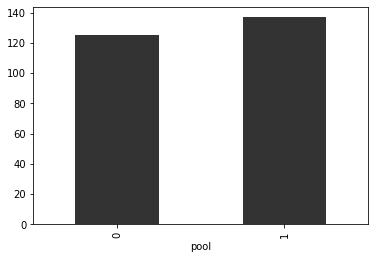

In [37]:
df_listing.groupby('pool').price.median().plot(kind='bar',color='k',alpha=0.8);

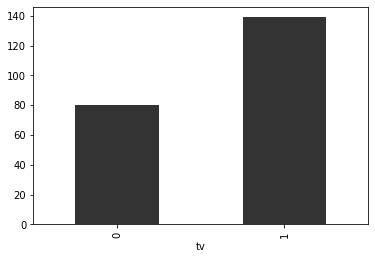

In [38]:
df_listing.groupby('tv').price.median().plot(kind='bar',color='k',alpha=0.8);

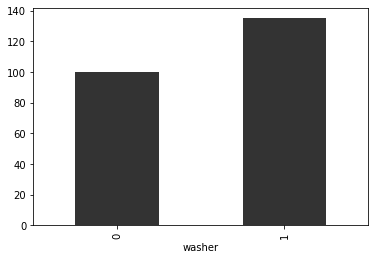

In [39]:
df_listing.groupby('washer').price.median().plot(kind='bar',color='k',alpha=0.8);

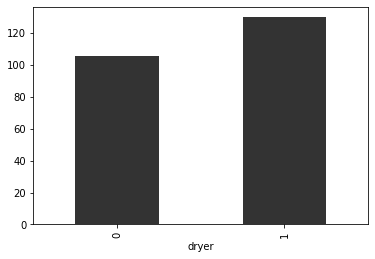

In [40]:
df_listing.groupby('dryer').price.median().plot(kind='bar',color='k',alpha=0.8);

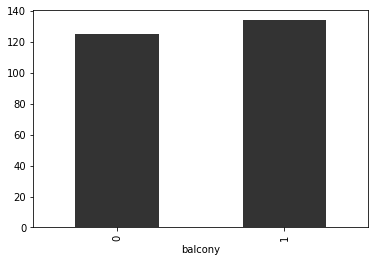

In [41]:
df_listing.groupby('balcony').price.median().plot(kind='bar',color='k',alpha=0.8);

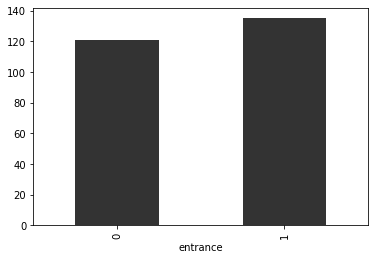

In [42]:
df_listing.groupby('entrance').price.median().plot(kind='bar',color='k',alpha=0.8);

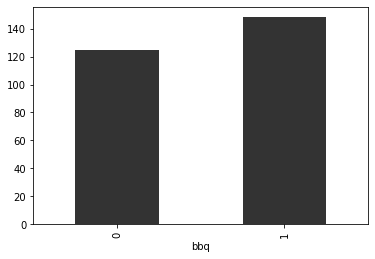

In [43]:
df_listing.groupby('bbq').price.median().plot(kind='bar',color='k',alpha=0.8);

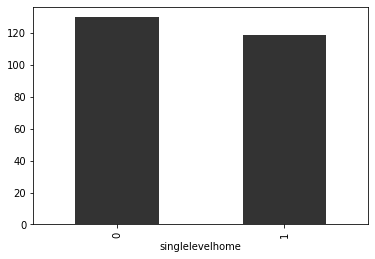

In [44]:
df_listing.groupby('singlelevelhome').price.median().plot(kind='bar',color='k',alpha=0.8);

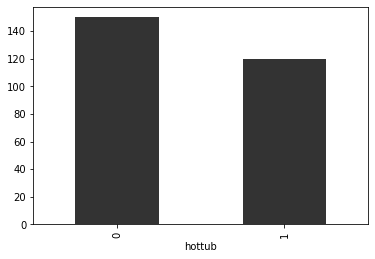

In [45]:
#fig,axs =plt.subplots(1,2,figsize=(12,4))
df_listing.groupby('hottub').price.median().plot(kind='bar',color='k',alpha=0.8);


In [46]:
df_listing.beds.fillna(value=0,inplace=True)
df_listing = df_listing[df_listing.host_is_superhost.notna()]
df_listing.Timeframe.fillna(value=0,inplace=True)

In [47]:
#df_listing.review_scores_rating.fillna(90,inplace=True)

In [48]:
df_listing.host_acceptance_rate = df_listing.host_acceptance_rate.replace('[%]','',regex=True).astype(float)

In [49]:
df_scrape.rename(columns={'link':'listing_url'},inplace=True)

In [50]:
df_listing = pd.merge(left=df_listing,right=df_scrape[['listing_url','cleaning_fee','service_fee','Final_score']],on='listing_url')

In [51]:
df_listing.columns

Index(['id', 'listing_url', 'host_id', 'host_since', 'host_location',
       'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'host_verifications', 'accommodates',
       'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights',
       'maximum_nights', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'Timeframe',
       'room_type__Hotel_room', 'room_type__Private_room',
       'room_type__Shared_room', 'bathrooms', 'property_type_Entire_bungalow',
       'property_type_Entire_condominium', 'property_type_Entire_guest_suite',
       'property_type_Entire_guesthouse', 'property_type_Entire_house',
       'property_type_Entire_serviced_apartment',


# Machine Learning Section

### Linear Regression

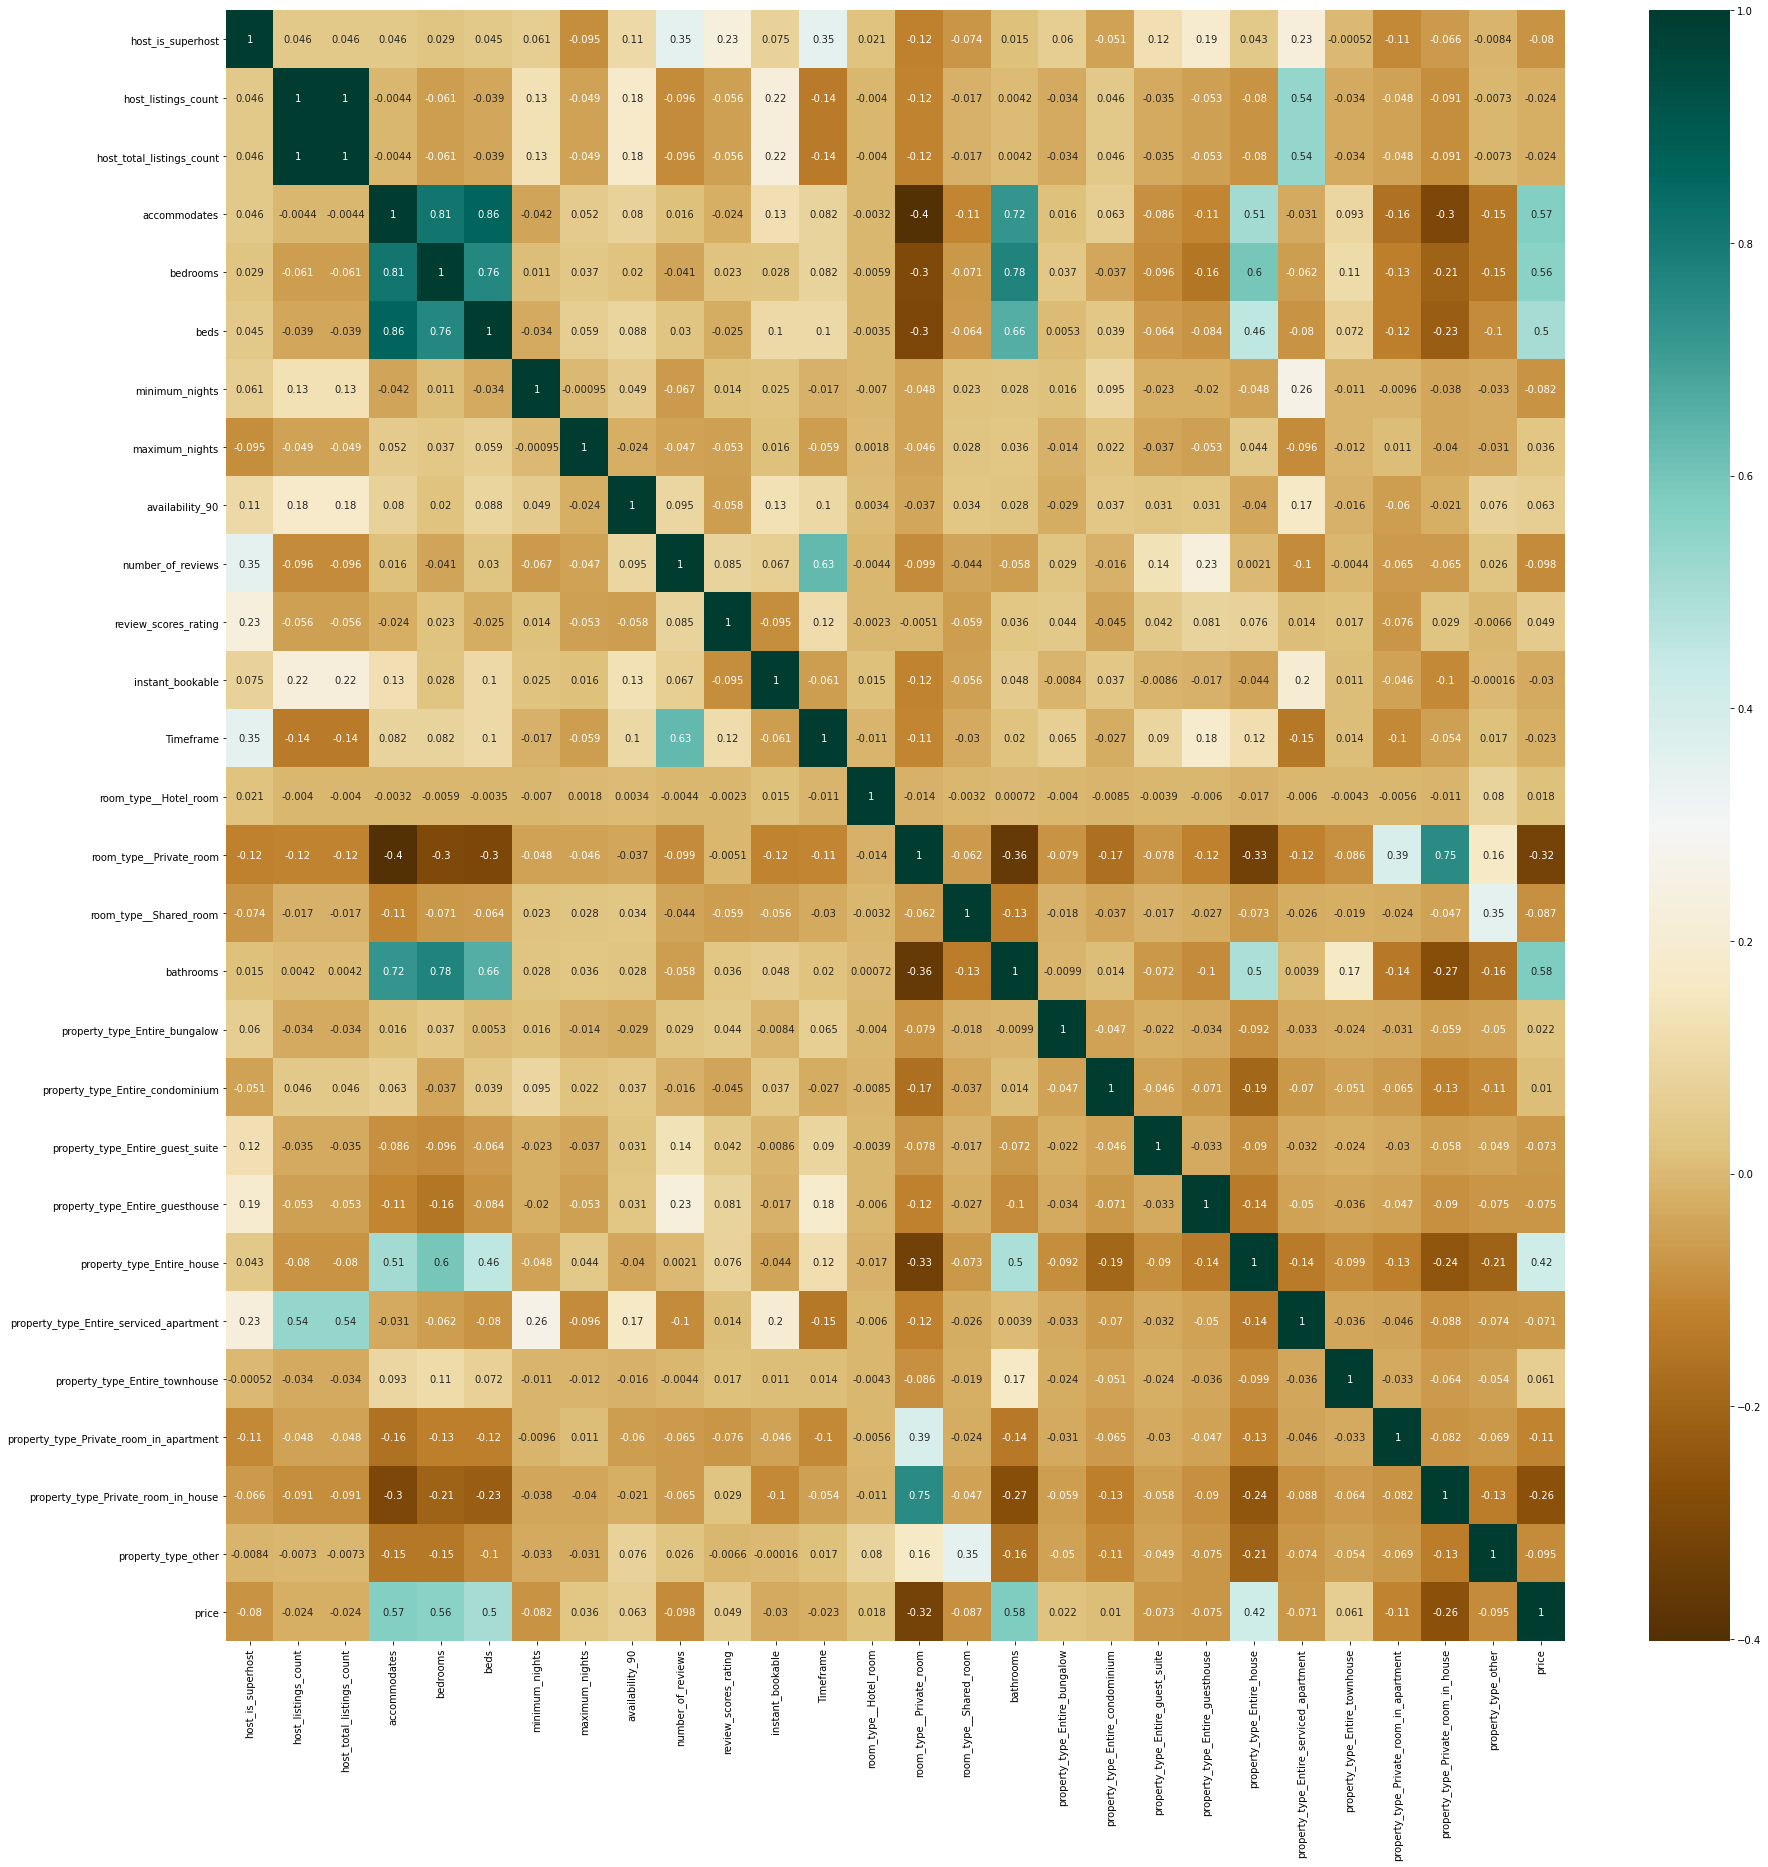

In [52]:
features_test =['host_is_superhost', 'host_listings_count',
           'host_total_listings_count',  #'zip_code',
           'accommodates', 'bedrooms', 'beds',
           'minimum_nights', 'maximum_nights', 'availability_90',
           'number_of_reviews', 'review_scores_rating', 'instant_bookable', 'Timeframe',
           'room_type__Hotel_room', 'room_type__Private_room',
           'room_type__Shared_room', 'bathrooms', 'property_type_Entire_bungalow',
           'property_type_Entire_condominium', 'property_type_Entire_guest_suite',
           'property_type_Entire_guesthouse', 'property_type_Entire_house',
           'property_type_Entire_serviced_apartment',
           'property_type_Entire_townhouse',
           'property_type_Private_room_in_apartment',
           'property_type_Private_room_in_house', 'property_type_other','price']
X_Corr = df_listing[features_test];
fig,ax = plt.subplots(figsize=(30,30));
sns.heatmap(X_Corr.corr(),annot=True,cmap='BrBG');

### Features to Consider

In [83]:
features =['host_is_superhost', 'host_listings_count',
           'host_total_listings_count',
           'accommodates', 'bedrooms', 'beds',
           'minimum_nights', 'maximum_nights', 'availability_90',
           'number_of_reviews', 'instant_bookable', 'Timeframe',
           'room_type__Private_room',
           'bathrooms', 'Final_score',
           'pool','tv','washer','dryer','balcony','entrance','bbq','hottub','singlelevelhome',
           'zipcode_78702', 'zipcode_78703', 'zipcode_78704', 'zipcode_78705',
           'zipcode_78712', 'zipcode_78717', 'zipcode_78719', 'zipcode_78721',
           'zipcode_78722', 'zipcode_78723', 'zipcode_78724', 'zipcode_78725',
           'zipcode_78726', 'zipcode_78727', 'zipcode_78728', 'zipcode_78729',
           'zipcode_78730', 'zipcode_78731', 'zipcode_78732', 'zipcode_78733',
           'zipcode_78734', 'zipcode_78735', 'zipcode_78736', 'zipcode_78737',
           'zipcode_78738', 'zipcode_78739', 'zipcode_78741', 'zipcode_78742',
           'zipcode_78744', 'zipcode_78745', 'zipcode_78746', 'zipcode_78747',
           'zipcode_78748', 'zipcode_78749', 'zipcode_78750', 'zipcode_78751',
           'zipcode_78752', 'zipcode_78753', 'zipcode_78754', 'zipcode_78756',
           'zipcode_78757', 'zipcode_78758', 'zipcode_78759','property_type_Entire_house']


# features =['host_is_superhost', 'host_listings_count',
#            'host_total_listings_count',  'zip_code',
#            'accommodates', 'bedrooms', 'beds',
#            'minimum_nights', 'maximum_nights', 'availability_90',
#            'number_of_reviews', 'review_scores_rating', 'instant_bookable', 'Timeframe',
#            'room_type__Hotel_room', 'room_type__Private_room',
#            'room_type__Shared_room', 'bathrooms', 'property_type_Entire_bungalow',
#            'property_type_Entire_condominium', 'property_type_Entire_guest_suite',
#            'property_type_Entire_guesthouse', 'property_type_Entire_house',
#            'property_type_Entire_serviced_apartment',
#            'property_type_Entire_townhouse',
#            'property_type_Private_room_in_apartment',
#            'property_type_Private_room_in_house', 'property_type_other', 'pool',
#            'tv', 'washer', 'dryer', 'balcony', 'entrance', 'bbq','hottub','singlelevelhome']
df_listing = df_listing[df_listing.Final_score!=0]

X = df_listing[features]
y= df_listing.price
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1)

In [84]:
# cor_feature = []
# cor_feature = features.copy()
# cor_feature.append('price')
# # X_Corr = df_listing[features.append('price')];
# fig,ax = plt.subplots(figsize=(30,30));
# sns.heatmap(df_listing[cor_feature].corr(),annot=True,cmap='BrBG');

In [85]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [86]:
cross_val_score(lr,X_train,y_train).mean()

0.6096480067676527

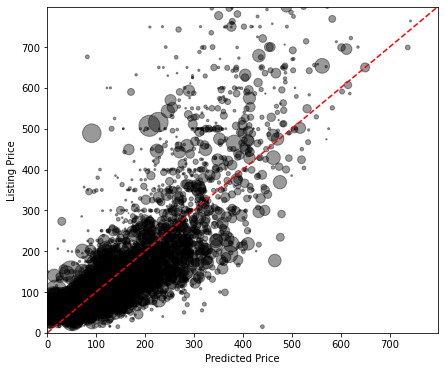

In [87]:
X_trial=[0,800]
y_trial=[0,800]
fig,ax = plt.subplots(figsize=(7,6));
model_checking(ax,lr,X_train,y_train)

In [88]:
y_test_predict = lr.predict(X_test)
r2_score(y_test,y_test_predict)

0.5804188246571548

In [59]:
g = pd.concat([X_train,y_train],axis=1);
g.columns
gg = g[['accommodates', 'bedrooms', 'beds', 'minimum_nights',
       'maximum_nights', 'availability_90', 'number_of_reviews',
       'bathrooms','Final_score', 'price']]

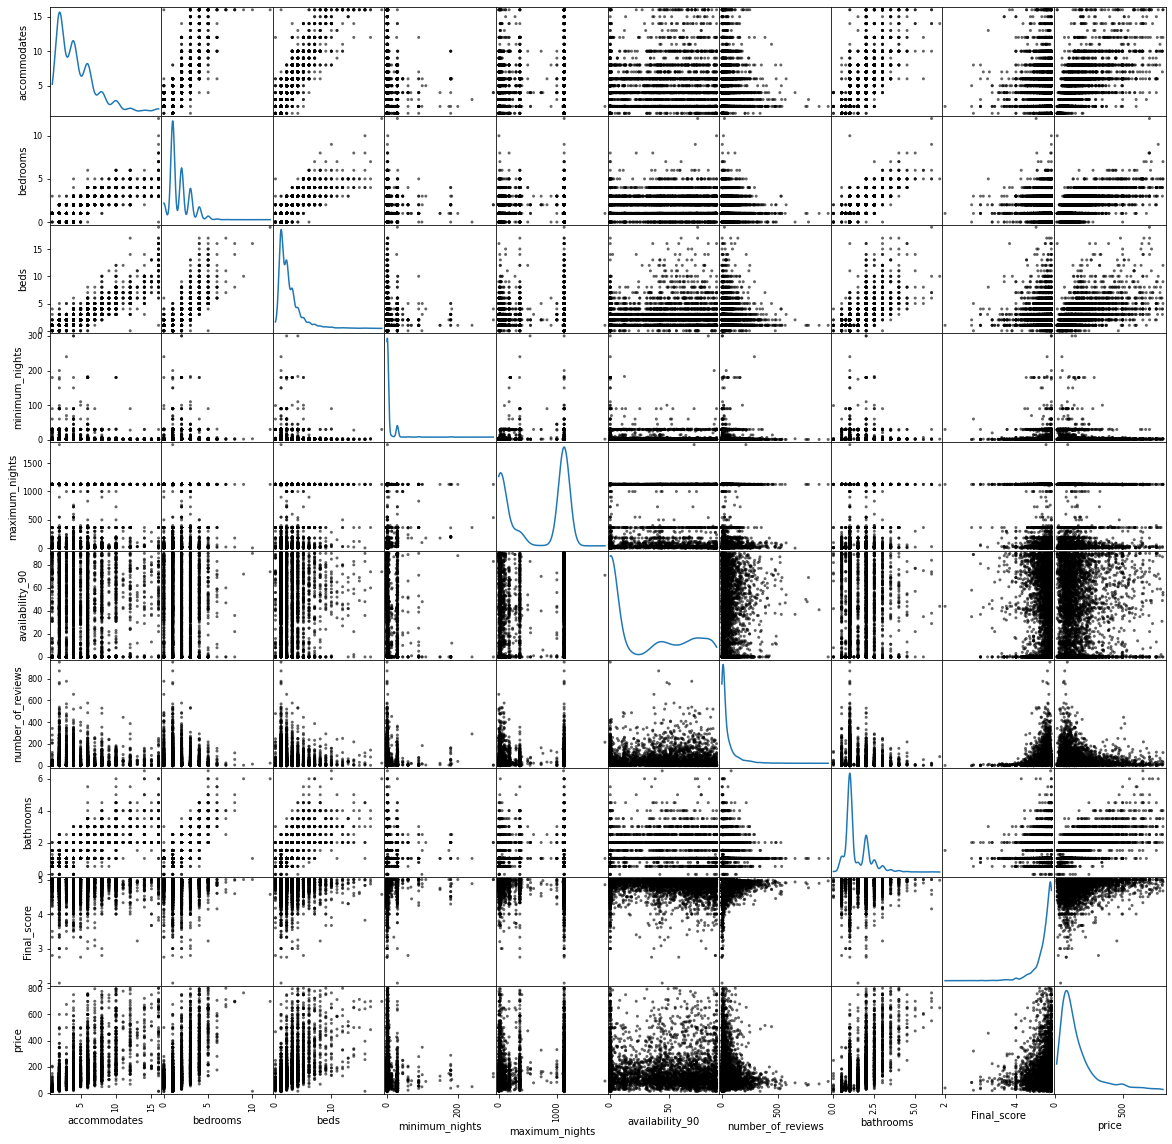

In [60]:
pd.plotting.scatter_matrix(gg,alpha=0.6,figsize=(20,20),diagonal='kde',c='k');

In [89]:
ss = StandardScaler()
ss.fit(X_train)
X_train_s = ss.transform(X_train)
X_test_s = ss.transform(X_test)
lasso = Lasso()
lasso.fit(X_train_s,y_train)
y_prediction = lasso.predict(X_test_s)
print('test',r2_score(y_test,y_prediction))
print('train',r2_score(y_train,lasso.predict(X_train_s)))

test 0.5805380919751171
train 0.6145448336813192


### Random Forest

In [90]:
rf = RandomForestRegressor(n_estimators=1000,max_depth=10,n_jobs=-1)
rf.fit(X_train,y_train)
cross_val_score(rf,X_train,y_train,scoring='r2').mean()
#r2_score(y_train,rf.predict(X_train))

0.6285061939167484

In [91]:
y_predicted = rf.predict(X_test)

In [92]:
r2_score(y_test,y_predicted)

0.6055703372499324

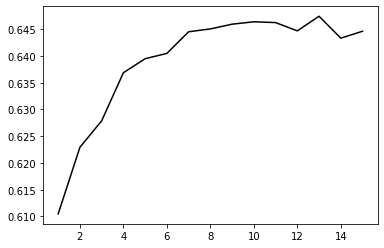

In [65]:
# Changing the number of features
feature_range = list(range(1,16))
scores=[]
for i in feature_range:
    rf = RandomForestRegressor(max_features=i,n_jobs=-1)
    score = cross_val_score(rf,X_train,y_train).mean()
    scores.append(score)
fig,ax = plt.subplots();
ax.plot(feature_range,scores,color='k');

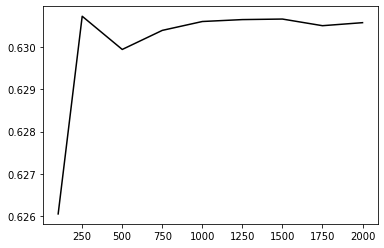

In [66]:
# Changing the number of trees
trees_numbers =[100,250,500,750,1000,1250,1500,1750,2000]
scores=[]
for number in trees_numbers:
    rf = RandomForestRegressor(n_estimators = number ,n_jobs=-1)
    score = cross_val_score(rf,X_train,y_train).mean()
    scores.append(score)
fig,ax = plt.subplots();
ax.plot(trees_numbers,scores,color='k');

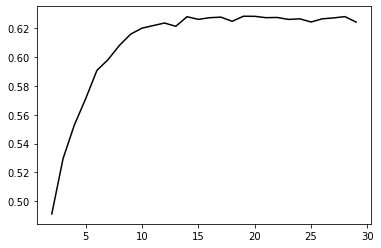

In [67]:
# Changing the depth
tree_depth = list(range(2,30))
scores=[]
for depth in tree_depth:
    rf = RandomForestRegressor(max_depth=depth,n_jobs=-1)
    score = cross_val_score(rf,X_train,y_train).mean()
    scores.append(score)
fig,ax = plt.subplots();
ax.plot(tree_depth,scores,color='k');

In [96]:
rf = RandomForestRegressor(max_depth=15,n_estimators = 1250,max_features=10)
cross_val_score(rf,X_train,y_train).mean()

0.6514855085843871

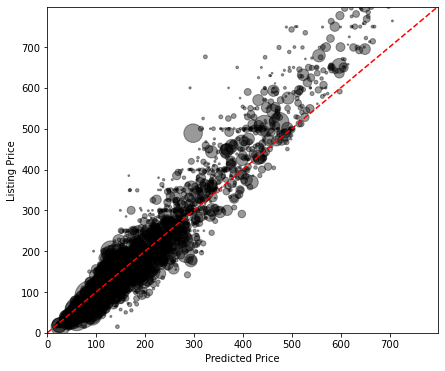

In [97]:
# Training dataset
rf.fit(X_train,y_train)
fig,ax = plt.subplots(figsize=(7,6))
model_checking(ax,rf,X_train,y_train);

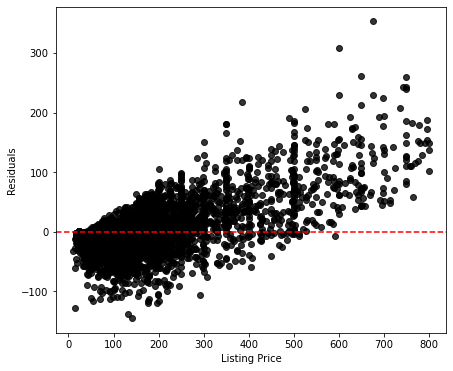

In [108]:
fig,ax = plt.subplots(figsize=(7,6))
y_residual = y_train - rf.predict(X_train)
ax.scatter(y_train,y_residual,c='k',alpha=0.8);
ax.axhline(0,color='r',ls='--');
ax.set_ylabel('Residuals');
ax.set_xlabel('Listing Price');

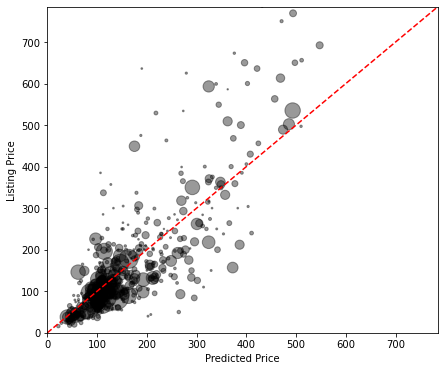

In [73]:
# Testing dataset
fig,ax = plt.subplots(figsize=(7,6))
model_checking(ax,rf,X_test,y_test);

In [80]:
df_listing[df_listing.price>400].head(5)

,id,listing_url,host_id,host_since,host_location,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,accommodates,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,Timeframe,room_type__Hotel_room,room_type__Private_room,room_type__Shared_room,bathrooms,property_type_Entire_bungalow,property_type_Entire_condominium,property_type_Entire_guest_suite,property_type_Entire_guesthouse,property_type_Entire_house,property_type_Entire_serviced_apartment,property_type_Entire_townhouse,property_type_Private_room_in_apartment,property_type_Private_room_in_house,property_type_other,zipcode_78702,zipcode_78703,zipcode_78704,zipcode_78705,zipcode_78712,zipcode_78717,zipcode_78719,zipcode_78721,zipcode_78722,zipcode_78723,zipcode_78724,zipcode_78725,zipcode_78726,zipcode_78727,zipcode_78728,zipcode_78729,zipcode_78730,zipcode_78731,zipcode_78732,zipcode_78733,zipcode_78734,zipcode_78735,zipcode_78736,zipcode_78737,zipcode_78738,zipcode_78739,zipcode_78741,zipcode_78742,zipcode_78744,zipcode_78745,zipcode_78746,zipcode_78747,zipcode_78748,zipcode_78749,zipcode_78750,zipcode_78751,zipcode_78752,zipcode_78753,zipcode_78754,zipcode_78756,zipcode_78757,zipcode_78758,zipcode_78759,pool,tv,washer,dryer,balcony,entrance,bbq,hottub,singlelevelhome,cleaning_fee,service_fee,Final_score
35,76911,https://www.airbnb.com/rooms/76911,394012,2011-02-15,"Austin, Texas, United States",94.0,1.0,1.0,1.0,"['email', 'phone', 'reviews', 'kba', 'work_ema...",12,5.0,17.0,"[""Free parking on premises"", ""Hair dryer"", ""Ba...",484.0,2,1125,27,50,74,349,143,99.0,10.0,10.0,10.0,10.0,10.0,10.0,0,2072.0,0,0,0,3.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,$200,$232,4.94
41,78035,https://www.airbnb.com/rooms/78035,419192,2011-03-02,"Austin, Texas, United States",83.0,1.0,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",4,4.0,4.0,"[""Free parking on premises"", ""Hair dryer"", ""Ba...",750.0,3,60,0,0,0,0,90,100.0,10.0,10.0,10.0,10.0,10.0,9.0,0,1145.0,0,0,0,3.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,NaN,NaN,4.99
67,158398,https://www.airbnb.com/rooms/158398,760426,2011-06-29,"Austin, Texas, United States",100.0,0.0,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",8,4.0,5.0,"[""Free parking on premises"", ""Hair dryer"", ""Ov...",499.0,3,30,5,22,52,327,11,98.0,10.0,10.0,10.0,10.0,9.0,9.0,0,2551.0,0,0,0,3.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,1,1,0,NaN,NaN,4.91
72,195674,https://www.airbnb.com/rooms/195674,951551,2011-08-10,"Austin, Texas, United States",50.0,0.0,1.0,1.0,"['email', 'phone', 'reviews', 'offline_governm...",10,4.0,5.0,"[""Indoor fireplace"", ""Hair dryer"", ""Free parki...",750.0,2,30,30,60,90,365,29,99.0,10.0,10.0,10.0,10.0,10.0,9.0,0,2274.0,0,0,0,2.5,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,1,0,$250,$247,4.97
81,222986,https://www.airbnb.com/rooms/222986,1157982,2011-09-14,"Austin, Texas, United States",70.0,1.0,4.0,4.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",8,3.0,3.0,"[""Free parking on premises"", ""Hair dryer"", ""Ba...",500.0,4,90,29,59,89,364,53,99.0,10.0,10.0,10.0,10.0,9.0,9.0,0,2148.0,0,0,0,2.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,1,0,$100,$296,4.96


## Feature importnace 

In [ ]:
rf = RandomForestRegressor(n_estimators=1000,max_features=10,n_jobs=-1,oob_score=True)
rf.fit(X_train,y_train)
rf.oob_score_

In [ ]:
# Plot the feature importance
feat_scores = pd.Series(rf.feature_importances_,
                           index=X.columns)
feat_scores = feat_scores.sort_values()
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,20),
                      color='b')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain');

In [ ]:
rf.feature_importances_

In [ ]:
# Permutation importance
result = permutation_importance(rf,X_test,y_test,n_jobs=2,n_repeats=10)
sorted_idx = result.importances_mean.argsort()


fig, ax = plt.subplots(figsize=(20,15))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [ ]:
model = RandomForestRegressor(n_estimators=250,max_features='auto',random_state=0)
model.fit(X_train, y_train)

In [ ]:
fig, ax = plt.subplots(figsize=(18,18))
plot_partial_dependence(model, X_train, [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17],target=1, ax=ax)
fig.tight_layout()

In [ ]:
## Gradient Boost 

In [ ]:
model = GradientBoostingRegressor(learning_rate=0.01,n_estimators=2000)


grid = {'max_depth':[2,4,8,12,16,24,32],
        'min_samples_split':[2,4,6,8,10]  }

In [ ]:
gb_gridsearch = GridSearchCV(estimator=model, param_grid=grid, 
                             cv=5, verbose=0, return_train_score=True)

gb_gridsearch.fit(X_train, y_train)

In [ ]:
df_gridsearch = pd.DataFrame(gb_gridsearch.cv_results_)

### XGBoost 

In [ ]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)

In [ ]:
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

In [ ]:
r2_score(training_preds_xgb_reg,y_train)

In [ ]:
r2_score(val_preds_xgb_reg,y_test)

In [ ]:
XX = [0,800]
yy = [0,800]
fig,ax = plt.subplots(figsize=(6,6))
ax.scatter(val_preds_xgb_reg,y_test,c='k',alpha=0.5);
ax.plot(XX,yy,ls='--',color='b');
ax.set_xlabel('Predicted Price');
ax.set_ylabel('Listing Price');

In [ ]:
# features =['host_is_superhost', 'host_listings_count',
#            'host_total_listings_count',  'zip_code',
#            'accommodates', 'bedrooms', 'beds',
#            'minimum_nights', 'maximum_nights', 'availability_90',
#            'number_of_reviews', 'instant_bookable', 'Timeframe',
#            'room_type__Private_room',
#            'bathrooms', 'Final_score',
#            'pool','tv','washer','dryer','balcony','entrance']

In [ ]:
round(739,-1)